**1)Install and Import Required Libraries**

In [6]:
# Section 1: Install and Import Required Libraries


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve, precision_recall_curve)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

**2) Upload Dataset and Load Data**

In [8]:
# Section 2: Upload Dataset and Load Data
from google.colab import files
uploaded = files.upload()

# Get the filename (it might have a slightly different name)
import io
filename = list(uploaded.keys())[0]
print(f"Uploaded file: {filename}")

# Load the dataset
df = pd.read_csv(io.BytesIO(uploaded[filename]))

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nStatistical Description:")
print(df.describe())

Saving loan_approval_dataset.csv to loan_approval_dataset.csv
Uploaded file: loan_approval_dataset.csv
Dataset Shape: (4269, 13)

First 5 rows:
   loan_id   no_of_dependents      education  self_employed   income_annum  \
0        1                  2       Graduate             No        9600000   
1        2                  0   Not Graduate            Yes        4100000   
2        3                  3       Graduate             No        9100000   
3        4                  3       Graduate             No        8200000   
4        5                  5   Not Graduate            Yes        9800000   

    loan_amount   loan_term   cibil_score   residential_assets_value  \
0      29900000          12           778                    2400000   
1      12200000           8           417                    2700000   
2      29700000          20           506                    7100000   
3      30700000           8           467                   18200000   
4      24200000          20

**3) Data Cleaning and Preprocessing**

In [12]:
# Section 3: Data Cleaning and Preprocessing
# Create a copy of the dataset
df_clean = df.copy()

# Clean column names (remove leading/trailing spaces)
df_clean.columns = df_clean.columns.str.strip()
print("Cleaned column names:", df_clean.columns.tolist())

# Handle missing values
print("\nMissing values before handling:")
print(df_clean.isnull().sum())

# Identify numerical and categorical columns
numerical_cols = ['income_annum', 'loan_amount', 'loan_term', 'cibil_score',
                  'residential_assets_value', 'commercial_assets_value',
                  'luxury_assets_value', 'bank_asset_value']

categorical_cols = ['education', 'self_employed']

# For numerical columns, fill with median
for col in numerical_cols:
    if col in df_clean.columns and df_clean[col].isnull().sum() > 0:
        median_val = df_clean[col].median()
        df_clean[col].fillna(median_val, inplace=True)
        print(f"Filled missing values in {col} with median: {median_val}")

# For categorical columns, fill with mode
for col in categorical_cols:
    if col in df_clean.columns and df_clean[col].isnull().sum() > 0:
        mode_val = df_clean[col].mode()[0]
        df_clean[col].fillna(mode_val, inplace=True)
        print(f"Filled missing values in {col} with mode: {mode_val}")

print("\nMissing values after handling:")
print(df_clean.isnull().sum())

# AFFICHER LES VALEURS UNIQUES AVANT ENCODING
print("\nUnique values before encoding:")
for col in categorical_cols:
    if col in df_clean.columns:
        print(f"{col}: {df_clean[col].unique()}")

# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    if col in df_clean.columns:
        le = LabelEncoder()
        df_clean[col] = le.fit_transform(df_clean[col])
        label_encoders[col] = le
        print(f"Encoded {col} with classes: {le.classes_}")

# CONVERTIR LA VARIABLE CIBLE - CORRECTION ICI
print(f"\nUnique values in loan_status before conversion: {df_clean['loan_status'].unique()}")

# Vérifier le format actuel de loan_status
if df_clean['loan_status'].dtype == 'object':
    # Si c'est du texte
    df_clean['loan_status'] = df_clean['loan_status'].str.strip().map({'Approved': 1, 'Rejected': 0})
    print("Converted loan_status from text to binary")
else:
    # Si c'est déjà numérique mais pas dans le bon format
    print("loan_status is already numeric, checking values...")
    # S'assurer qu'il n'y a que 0 et 1
    unique_vals = df_clean['loan_status'].unique()
    if set(unique_vals).issubset({0, 1}):
        print("loan_status already has binary values (0, 1)")
    else:
        print(f"Unexpected values in loan_status: {unique_vals}")
        # Normaliser les valeurs si nécessaire
        df_clean['loan_status'] = df_clean['loan_status'].apply(lambda x: 1 if x > 0 else 0)
        print("Normalized loan_status to binary (0, 1)")

print(f"Unique values in loan_status after conversion: {df_clean['loan_status'].unique()}")
print(f"Value counts:\n{df_clean['loan_status'].value_counts()}")

# Display cleaned dataset info
print("\nCleaned Dataset Info:")
print(df_clean.info())
print("\nFirst 5 rows of cleaned data:")
print(df_clean.head())

Cleaned column names: ['loan_id', 'no_of_dependents', 'education', 'self_employed', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value', 'loan_status']

Missing values before handling:
loan_id                     0
no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64

Missing values after handling:
loan_id                     0
no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commer

**4) Exploratory Data Analysis (EDA)**

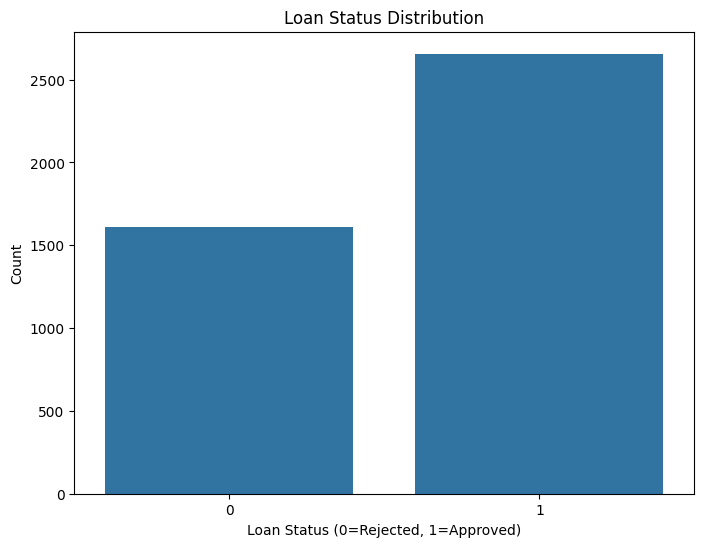

Class distribution:
loan_status
1    2656
0    1613
Name: count, dtype: int64
Imbalance ratio: 0.61


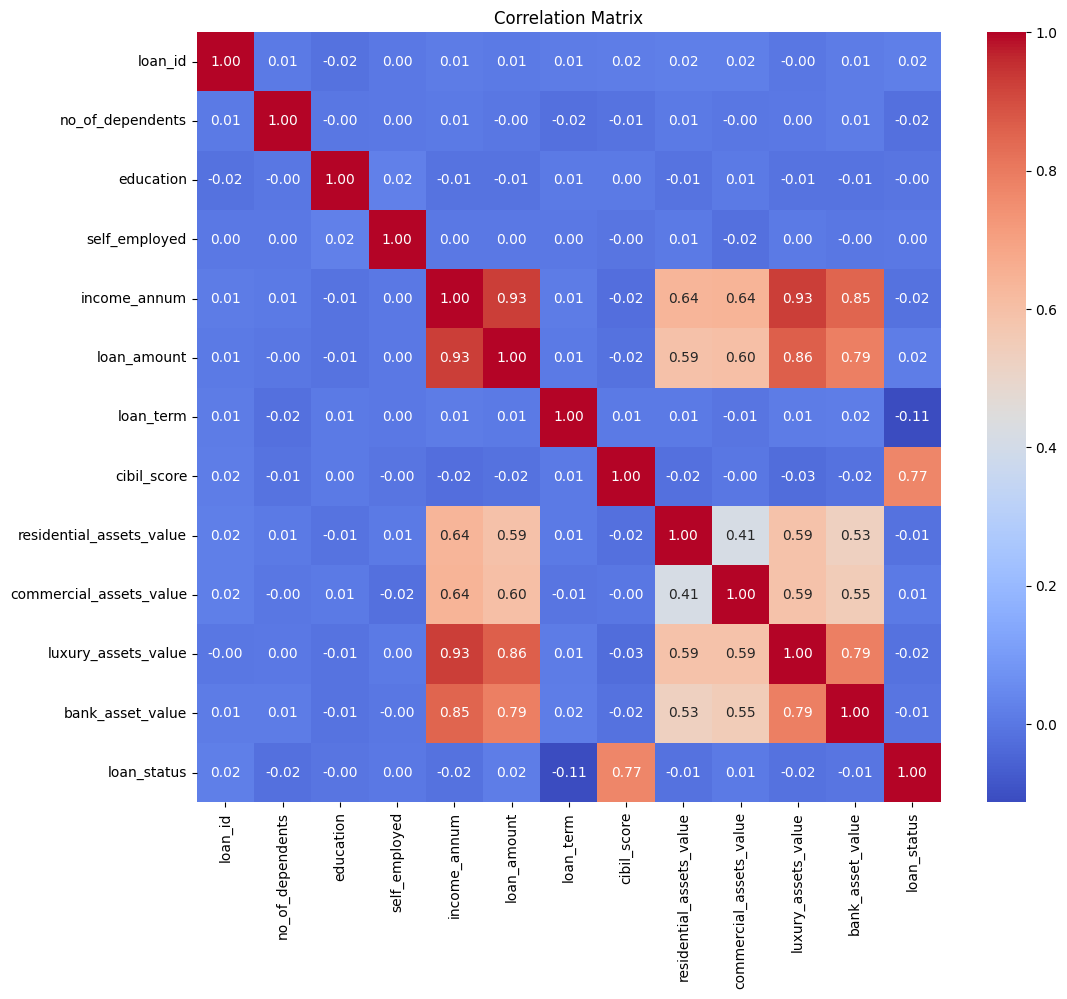

Numerical columns found: ['income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']


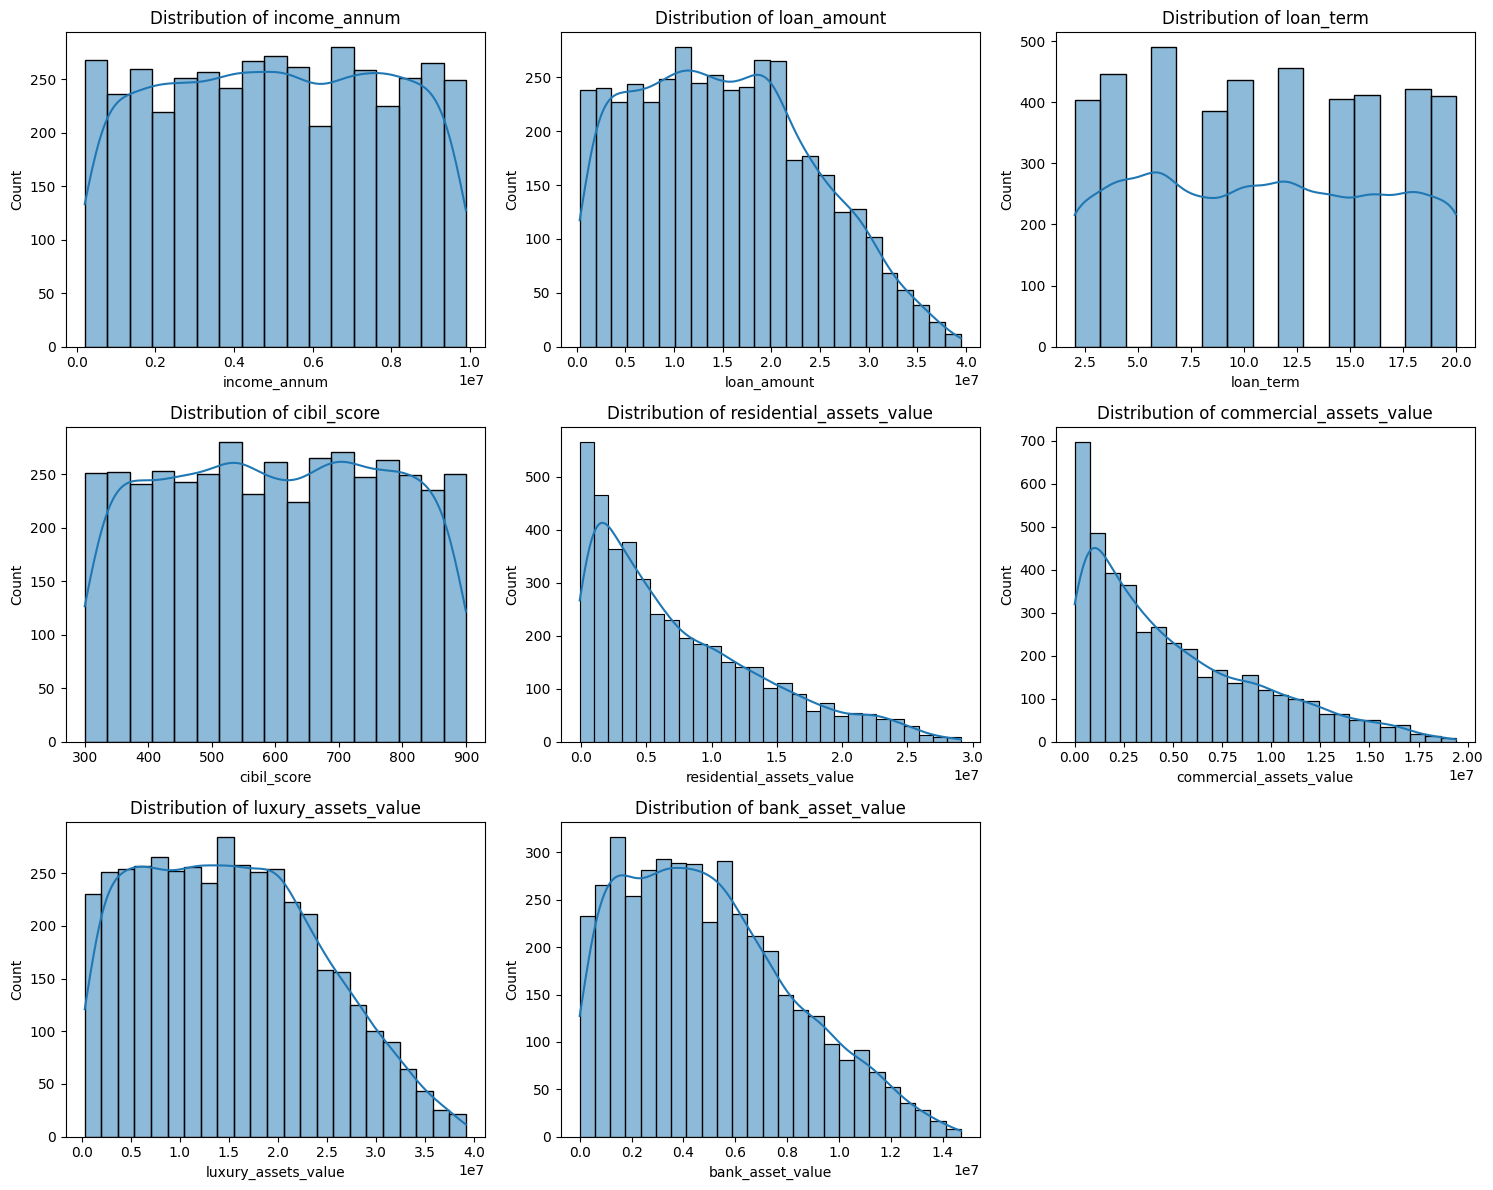

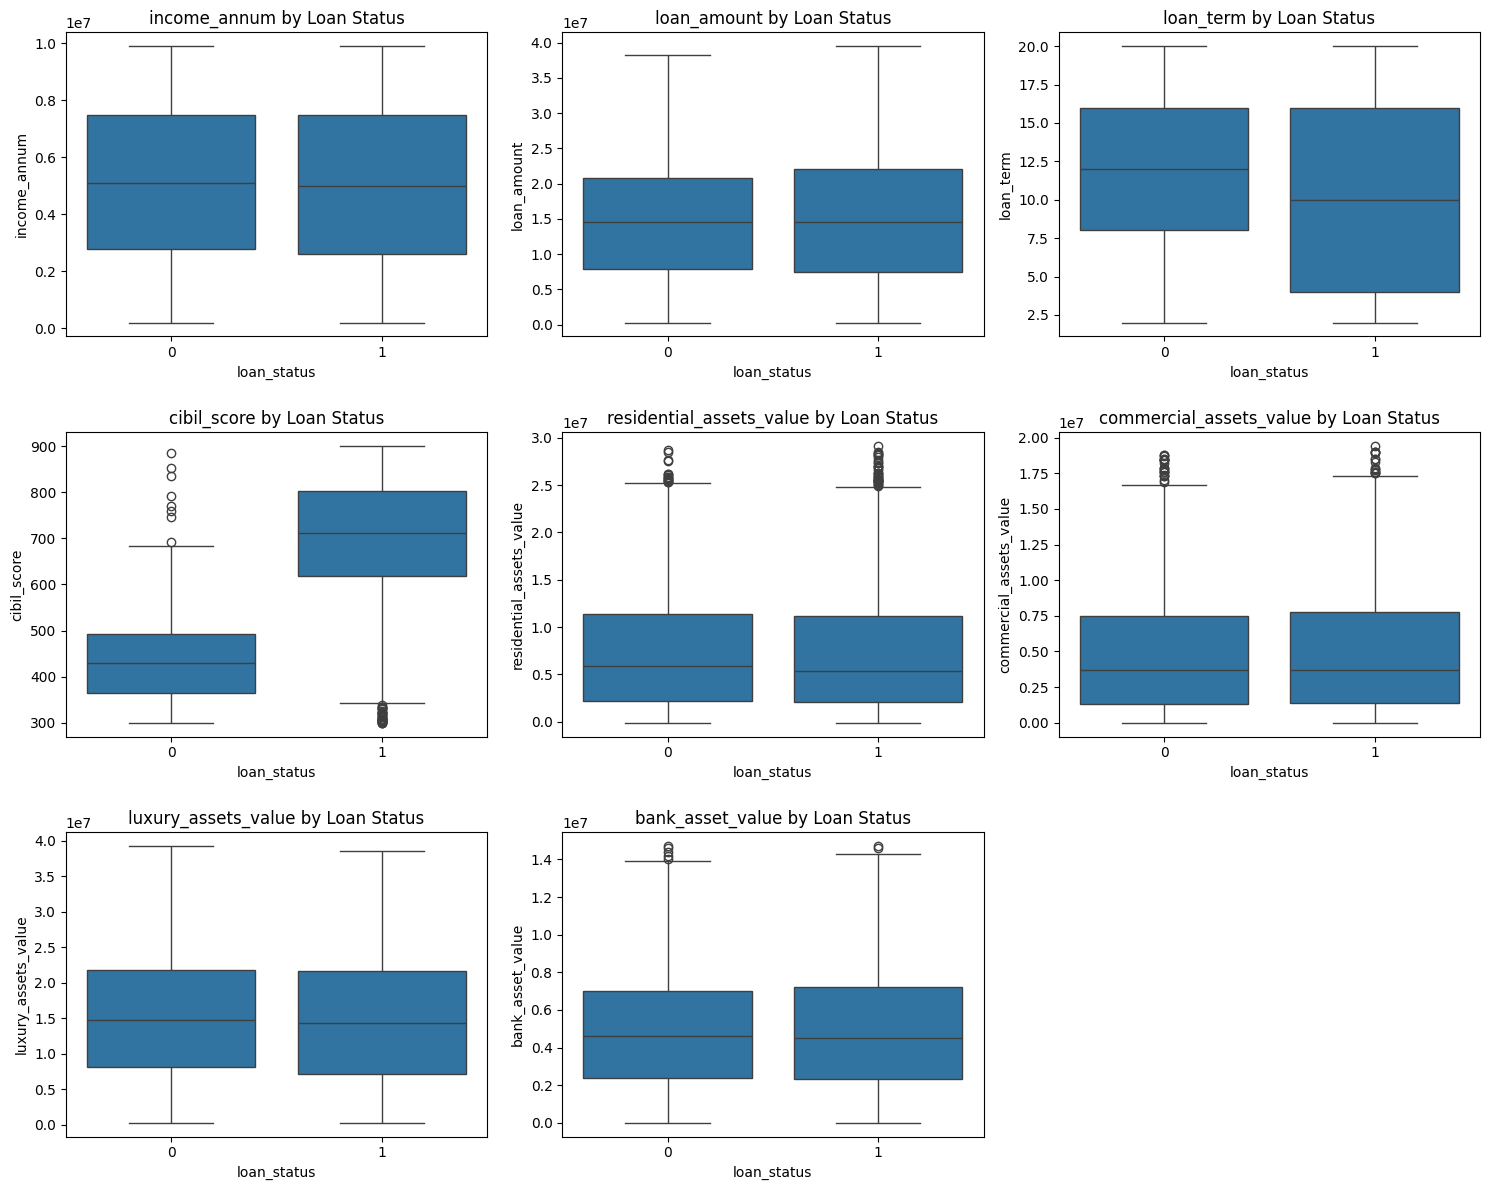


Dataset shape: (4269, 13)
Column names: ['loan_id', 'no_of_dependents', 'education', 'self_employed', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value', 'loan_status']
Data types:
 loan_id                     int64
no_of_dependents            int64
education                   int64
self_employed               int64
income_annum                int64
loan_amount                 int64
loan_term                   int64
cibil_score                 int64
residential_assets_value    int64
commercial_assets_value     int64
luxury_assets_value         int64
bank_asset_value            int64
loan_status                 int64
dtype: object

First few rows:
   loan_id  no_of_dependents  education  self_employed  income_annum  \
0        1                 2          0              0       9600000   
1        2                 0          1              1       4100000   
2        3             

In [13]:
# Section 4: Exploratory Data Analysis (EDA)
# Check class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='loan_status', data=df_clean)
plt.title('Loan Status Distribution')
plt.xlabel('Loan Status (0=Rejected, 1=Approved)')
plt.ylabel('Count')
plt.show()

print("Class distribution:")
print(df_clean['loan_status'].value_counts())

# Check if we have both classes
if len(df_clean['loan_status'].value_counts()) >= 2:
    print(f"Imbalance ratio: {df_clean['loan_status'].value_counts()[0] / df_clean['loan_status'].value_counts()[1]:.2f}")
else:
    print("Warning: Not enough classes for imbalance ratio calculation")

# Check if we have data to plot correlation matrix
if len(df_clean.columns) > 1:
    # Correlation matrix
    plt.figure(figsize=(12, 10))
    correlation_matrix = df_clean.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix')
    plt.show()
else:
    print("Not enough columns for correlation matrix")

# Distribution of numerical features
numerical_cols = ['income_annum', 'loan_amount', 'loan_term', 'cibil_score',
                  'residential_assets_value', 'commercial_assets_value',
                  'luxury_assets_value', 'bank_asset_value']

# Filter to only include columns that exist in the dataset
numerical_cols = [col for col in numerical_cols if col in df_clean.columns]

print(f"Numerical columns found: {numerical_cols}")

if numerical_cols:
    # Create subplots only for the number of numerical columns we have
    n_cols = len(numerical_cols)
    n_rows = (n_cols + 2) // 3  # Calculate rows needed (3 columns per row)

    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 4*n_rows))
    axes = axes.ravel()

    for i, col in enumerate(numerical_cols):
        sns.histplot(df_clean[col], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')

    # Hide any empty subplots
    for i in range(len(numerical_cols), len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()
else:
    print("No numerical columns found for distribution plots")

# Boxplots to identify outliers - only if we have both loan_status and numerical data
if 'loan_status' in df_clean.columns and numerical_cols:
    # Check if loan_status has at least 2 unique values
    if df_clean['loan_status'].nunique() >= 2:
        n_cols = len(numerical_cols)
        n_rows = (n_cols + 2) // 3  # Calculate rows needed (3 columns per row)

        fig, axes = plt.subplots(n_rows, 3, figsize=(15, 4*n_rows))
        axes = axes.ravel()

        for i, col in enumerate(numerical_cols):
            sns.boxplot(x='loan_status', y=col, data=df_clean, ax=axes[i])
            axes[i].set_title(f'{col} by Loan Status')

        # Hide any empty subplots
        for i in range(len(numerical_cols), len(axes)):
            axes[i].set_visible(False)

        plt.tight_layout()
        plt.show()
    else:
        print("Not enough unique values in loan_status for boxplots")
else:
    print("Missing loan_status or numerical columns for boxplots")

# Additional diagnostic information
print("\nDataset shape:", df_clean.shape)
print("Column names:", df_clean.columns.tolist())
print("Data types:\n", df_clean.dtypes)
print("\nFirst few rows:")
print(df_clean.head())

**5) Prepare Data for Modeling**

In [14]:
# Section 5: Prepare Data for Modeling
# Separate features and target
X = df_clean.drop(['loan_id', 'loan_status'], axis=1)
y = df_clean['loan_status']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Class distribution in training set:")
print(pd.Series(y_train).value_counts())

Training set shape: (3415, 11)
Testing set shape: (854, 11)
Class distribution in training set:
loan_status
1    2125
0    1290
Name: count, dtype: int64


**6) Baseline Models (Without Handling Imbalance)**


Logistic Regression Performance:
Accuracy: 0.9133
Precision: 0.9208
Recall: 0.9416
F1-Score: 0.9311
ROC-AUC: 0.9726


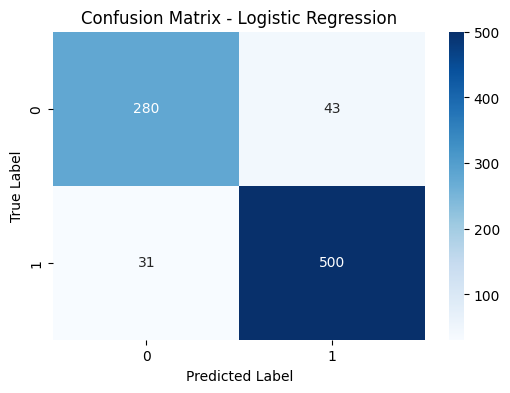


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       323
           1       0.92      0.94      0.93       531

    accuracy                           0.91       854
   macro avg       0.91      0.90      0.91       854
weighted avg       0.91      0.91      0.91       854



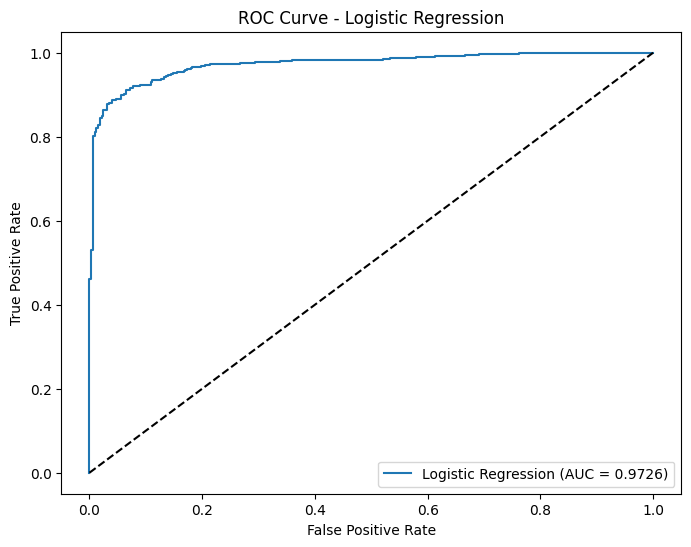


Decision Tree Performance:
Accuracy: 0.9813
Precision: 0.9849
Recall: 0.9849
F1-Score: 0.9849
ROC-AUC: 0.9801


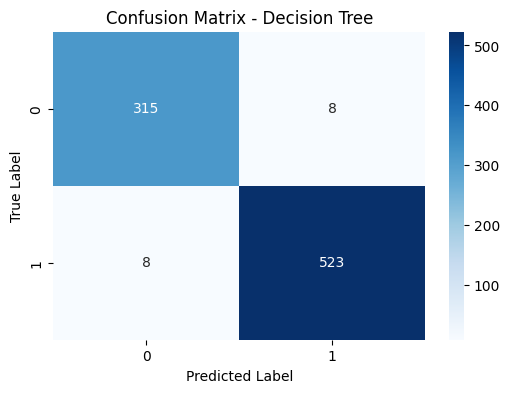


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       323
           1       0.98      0.98      0.98       531

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854



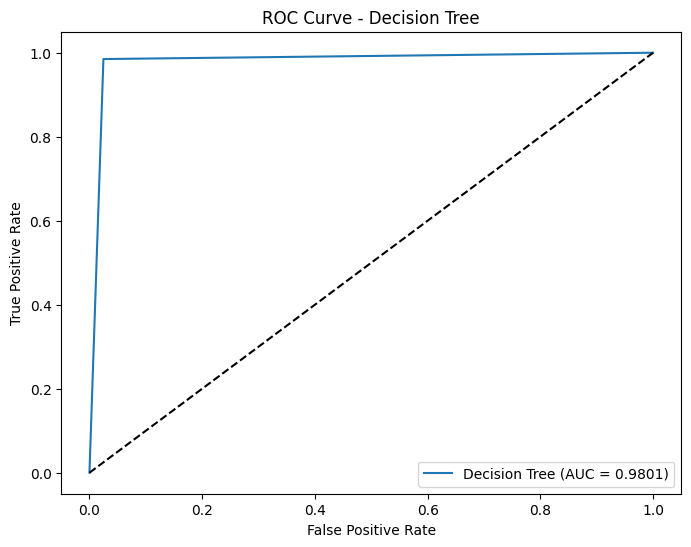


Baseline Models Comparison:
           Logistic Regression  Decision Tree
Accuracy              0.913349       0.981265
Precision             0.920810       0.984934
Recall                0.941620       0.984934
F1-Score              0.931099       0.984934
ROC-AUC               0.972550       0.980083


In [15]:
# Section 6: Baseline Models (Without Handling Imbalance)
# Function to evaluate models
def evaluate_model(model, X_test, y_test, model_name=""):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    print(f"\n{model_name} Performance:")
    print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
    print("Precision: {:.4f}".format(precision_score(y_test, y_pred)))
    print("Recall: {:.4f}".format(recall_score(y_test, y_pred)))
    print("F1-Score: {:.4f}".format(f1_score(y_test, y_pred)))

    if y_prob is not None:
        print("ROC-AUC: {:.4f}".format(roc_auc_score(y_test, y_prob)))

    # Confusion matrix
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # ROC Curve if probabilities are available
    if y_prob is not None:
        plt.figure(figsize=(8, 6))
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_score(y_test, y_prob):.4f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend()
        plt.show()

    return {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_prob) if y_prob is not None else None
    }

# Train and evaluate Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
lr_results = evaluate_model(lr_model, X_test_scaled, y_test, "Logistic Regression")

# Train and evaluate Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_scaled, y_train)
dt_results = evaluate_model(dt_model, X_test_scaled, y_test, "Decision Tree")

# Compare baseline models
baseline_results = pd.DataFrame({
    'Logistic Regression': lr_results,
    'Decision Tree': dt_results
})
print("\nBaseline Models Comparison:")
print(baseline_results)

**7) Handling Class Imbalance with SMOTE**

Class distribution after SMOTE:
loan_status
1    2125
0    2125
Name: count, dtype: int64

Logistic Regression with SMOTE Performance:
Accuracy: 0.9227
Precision: 0.9515
Recall: 0.9228
F1-Score: 0.9369
ROC-AUC: 0.9732


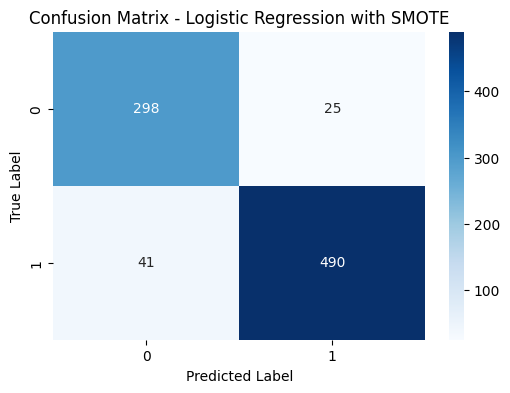


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       323
           1       0.95      0.92      0.94       531

    accuracy                           0.92       854
   macro avg       0.92      0.92      0.92       854
weighted avg       0.92      0.92      0.92       854



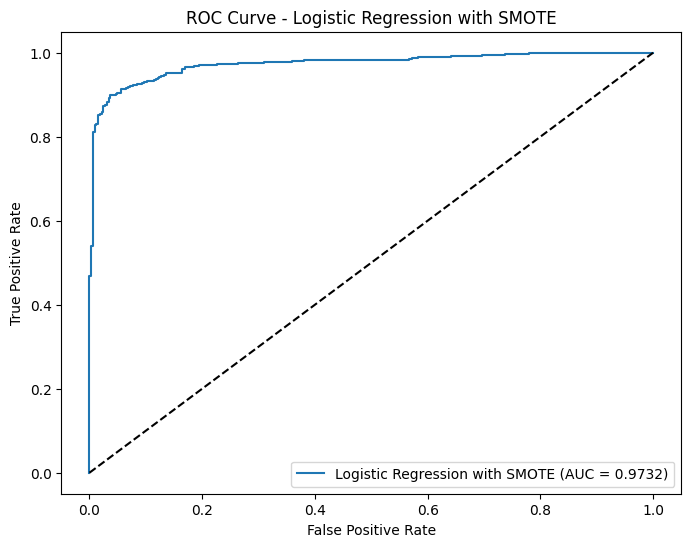


Decision Tree with SMOTE Performance:
Accuracy: 0.9789
Precision: 0.9794
Recall: 0.9868
F1-Score: 0.9831
ROC-AUC: 0.9764


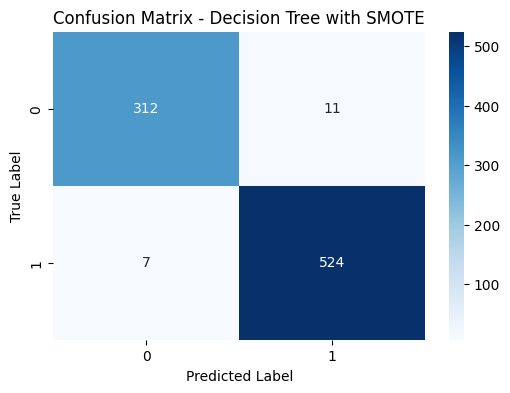


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       323
           1       0.98      0.99      0.98       531

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854



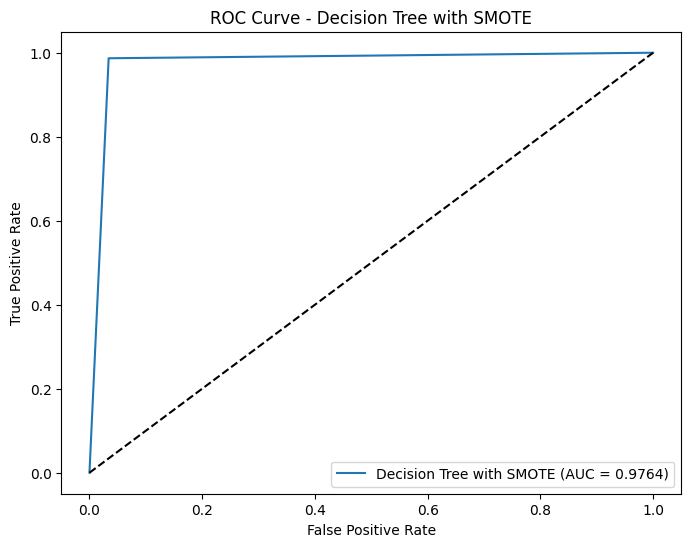


Models with SMOTE Comparison:
           Logistic Regression with SMOTE  Decision Tree with SMOTE
Accuracy                         0.922717                  0.978923
Precision                        0.951456                  0.979439
Recall                           0.922787                  0.986817
F1-Score                         0.936902                  0.983114
ROC-AUC                          0.973186                  0.976381


In [16]:
# Section 7: Handling Class Imbalance with SMOTE
# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print("Class distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts())

# Train models with SMOTE data
lr_model_smote = LogisticRegression(random_state=42, max_iter=1000)
lr_model_smote.fit(X_train_smote, y_train_smote)
lr_smote_results = evaluate_model(lr_model_smote, X_test_scaled, y_test, "Logistic Regression with SMOTE")

dt_model_smote = DecisionTreeClassifier(random_state=42)
dt_model_smote.fit(X_train_smote, y_train_smote)
dt_smote_results = evaluate_model(dt_model_smote, X_test_scaled, y_test, "Decision Tree with SMOTE")

# Compare models with SMOTE
smote_results = pd.DataFrame({
    'Logistic Regression with SMOTE': lr_smote_results,
    'Decision Tree with SMOTE': dt_smote_results
})
print("\nModels with SMOTE Comparison:")
print(smote_results)

**8) Additional Techniques - Class Weight and UnderSampling**


Logistic Regression with Class Weight Performance:
Accuracy: 0.9239
Precision: 0.9551
Recall: 0.9209
F1-Score: 0.9377
ROC-AUC: 0.9734


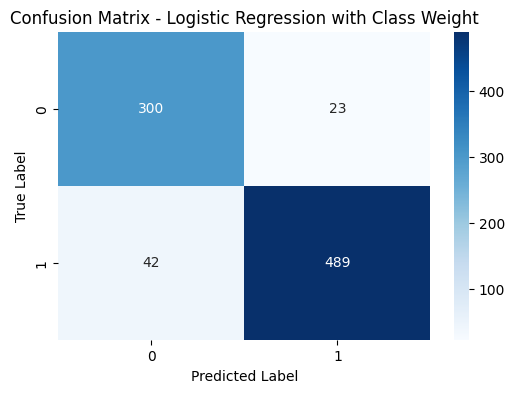


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       323
           1       0.96      0.92      0.94       531

    accuracy                           0.92       854
   macro avg       0.92      0.92      0.92       854
weighted avg       0.93      0.92      0.92       854



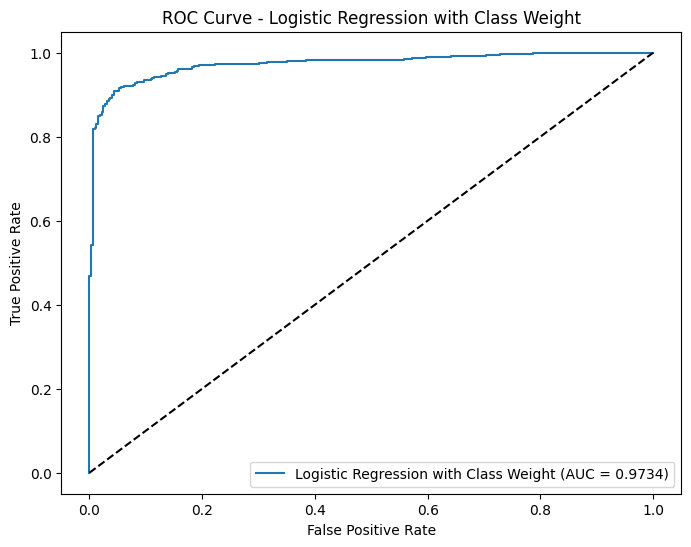


Decision Tree with Class Weight Performance:
Accuracy: 0.9766
Precision: 0.9776
Recall: 0.9849
F1-Score: 0.9812
ROC-AUC: 0.9739


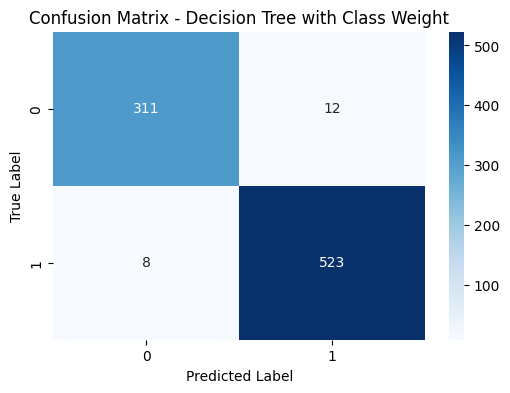


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       323
           1       0.98      0.98      0.98       531

    accuracy                           0.98       854
   macro avg       0.98      0.97      0.98       854
weighted avg       0.98      0.98      0.98       854



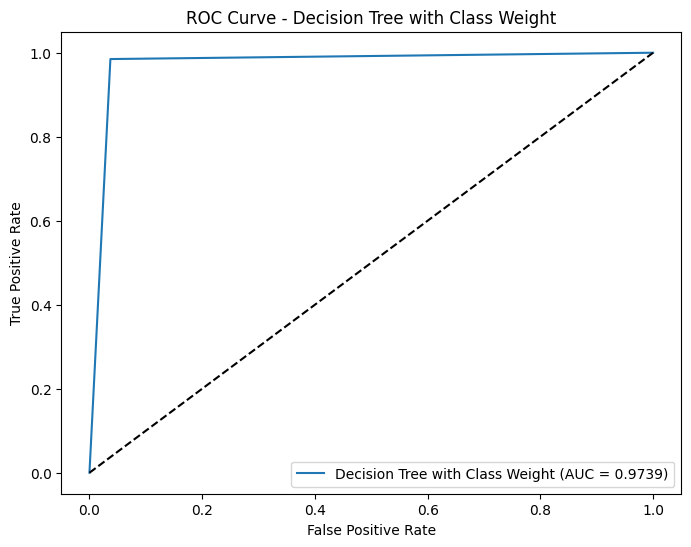


Logistic Regression with UnderSampling Performance:
Accuracy: 0.9239
Precision: 0.9551
Recall: 0.9209
F1-Score: 0.9377
ROC-AUC: 0.9736


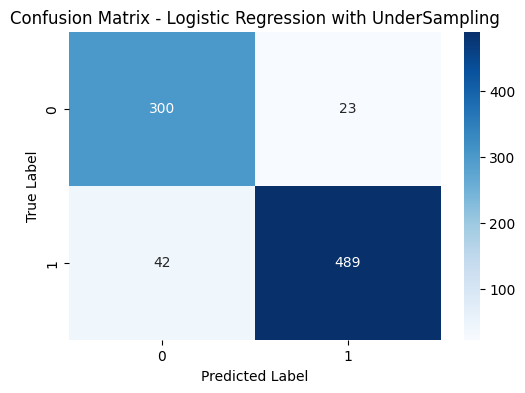


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       323
           1       0.96      0.92      0.94       531

    accuracy                           0.92       854
   macro avg       0.92      0.92      0.92       854
weighted avg       0.93      0.92      0.92       854



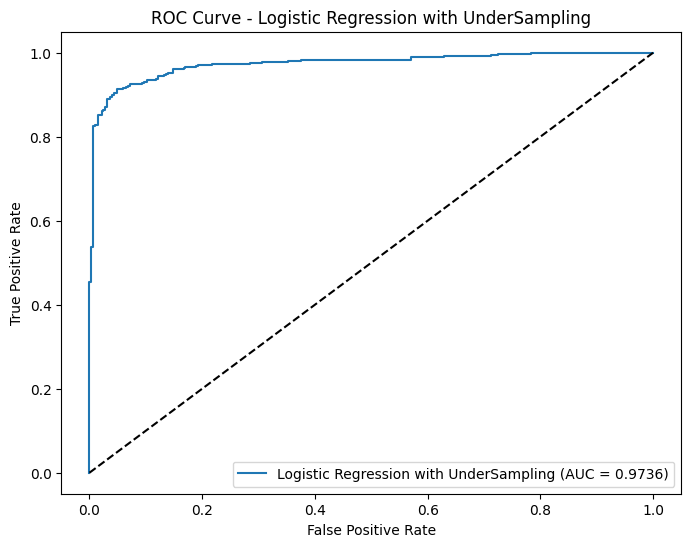


Decision Tree with UnderSampling Performance:
Accuracy: 0.9789
Precision: 0.9867
Recall: 0.9793
F1-Score: 0.9830
ROC-AUC: 0.9788


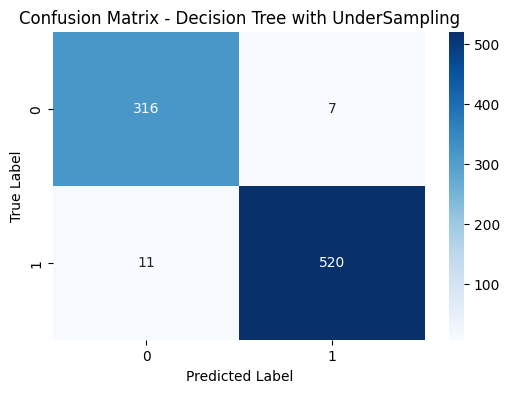


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       323
           1       0.99      0.98      0.98       531

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854



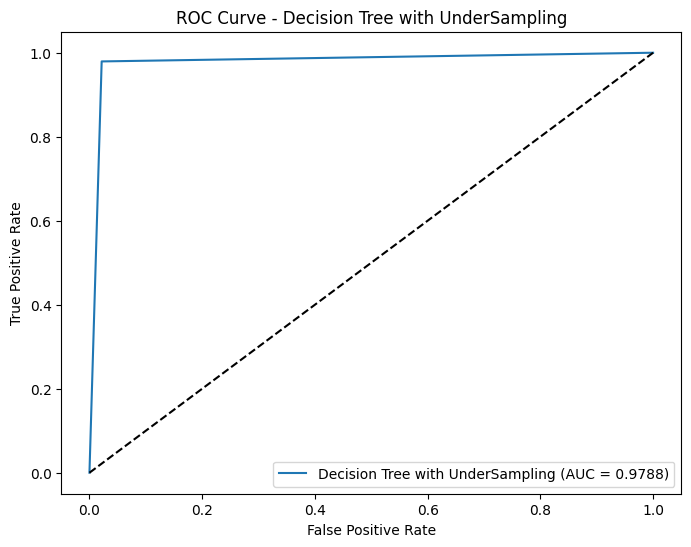


All Techniques Comparison:
                       Accuracy  Precision    Recall  F1-Score   ROC-AUC
LR Baseline            0.913349   0.920810  0.941620  0.931099  0.972550
DT Baseline            0.981265   0.984934  0.984934  0.984934  0.980083
LR with SMOTE          0.922717   0.951456  0.922787  0.936902  0.973186
DT with SMOTE          0.978923   0.979439  0.986817  0.983114  0.976381
LR with Class Weight   0.923888   0.955078  0.920904  0.937680  0.973442
DT with Class Weight   0.976581   0.977570  0.984934  0.981238  0.973891
LR with UnderSampling  0.923888   0.955078  0.920904  0.937680  0.973594
DT with UnderSampling  0.978923   0.986717  0.979284  0.982987  0.978806


In [17]:
# Section 8: Additional Techniques - Class Weight and UnderSampling
# Logistic Regression with class weights
lr_weighted = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
lr_weighted.fit(X_train_scaled, y_train)
lr_weighted_results = evaluate_model(lr_weighted, X_test_scaled, y_test, "Logistic Regression with Class Weight")

# Decision Tree with class weights
dt_weighted = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt_weighted.fit(X_train_scaled, y_train)
dt_weighted_results = evaluate_model(dt_weighted, X_test_scaled, y_test, "Decision Tree with Class Weight")

# Random UnderSampling
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_scaled, y_train)

lr_rus = LogisticRegression(random_state=42, max_iter=1000)
lr_rus.fit(X_train_rus, y_train_rus)
lr_rus_results = evaluate_model(lr_rus, X_test_scaled, y_test, "Logistic Regression with UnderSampling")

dt_rus = DecisionTreeClassifier(random_state=42)
dt_rus.fit(X_train_rus, y_train_rus)
dt_rus_results = evaluate_model(dt_rus, X_test_scaled, y_test, "Decision Tree with UnderSampling")

# Compare all techniques
all_results = pd.DataFrame({
    'LR Baseline': lr_results,
    'DT Baseline': dt_results,
    'LR with SMOTE': lr_smote_results,
    'DT with SMOTE': dt_smote_results,
    'LR with Class Weight': lr_weighted_results,
    'DT with Class Weight': dt_weighted_results,
    'LR with UnderSampling': lr_rus_results,
    'DT with UnderSampling': dt_rus_results
})

print("\nAll Techniques Comparison:")
print(all_results.T)

**9) Hyperparameter Tuning for Best Model**

Best parameters: {'classifier__C': 0.01, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Best cross-validation score (F1): 0.9462345601776428

Tuned Logistic Regression with SMOTE Performance:
Accuracy: 0.9496
Precision: 0.9784
Recall: 0.9397
F1-Score: 0.9587
ROC-AUC: 0.9739


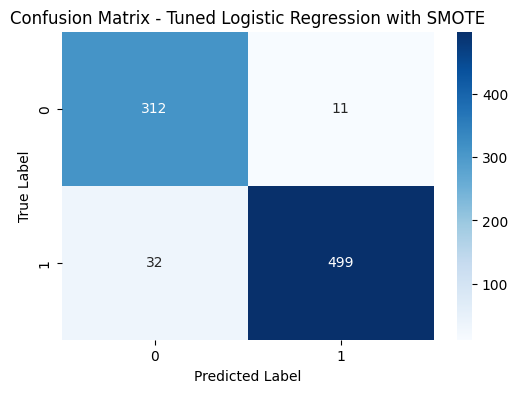


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       323
           1       0.98      0.94      0.96       531

    accuracy                           0.95       854
   macro avg       0.94      0.95      0.95       854
weighted avg       0.95      0.95      0.95       854



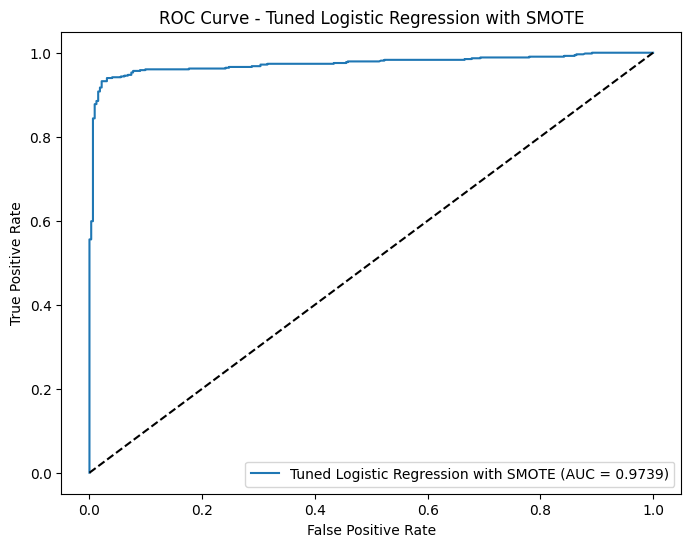

In [18]:
# Section 9: Hyperparameter Tuning for Best Model
# Based on results, let's tune the Logistic Regression with SMOTE
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Create SMOTE + Logistic Regression pipeline
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Grid search with cross-validation
grid_search = GridSearchCV(
    pipeline,
    param_grid={'classifier__' + key: value for key, value in param_grid.items()},
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (F1):", grid_search.best_score_)

# Evaluate the best model
best_model = grid_search.best_estimator_
best_results = evaluate_model(best_model, X_test_scaled, y_test, "Tuned Logistic Regression with SMOTE")

**10) Feature Importance and Final Evaluation**

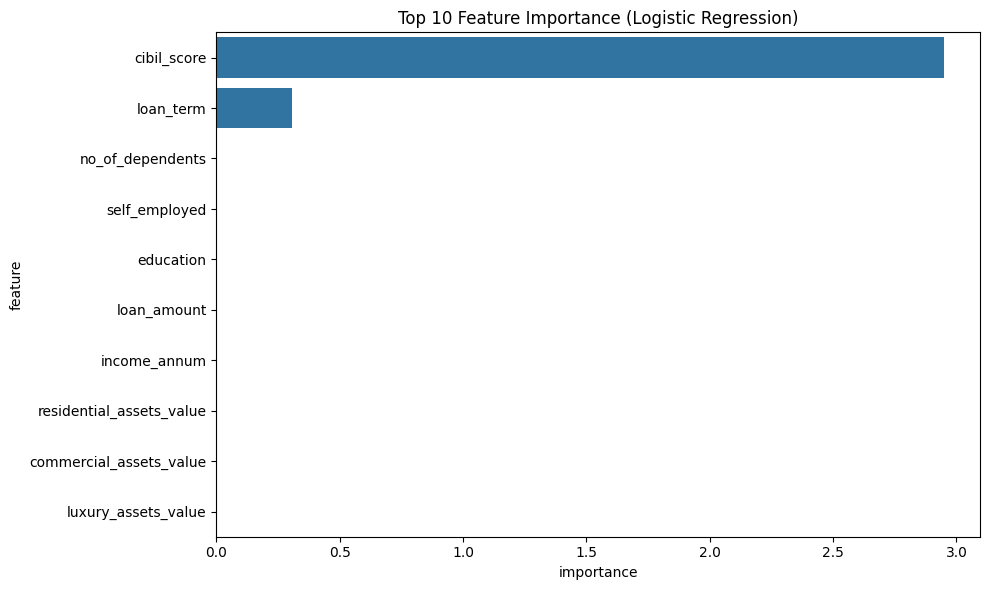

FINAL MODEL EVALUATION

Final Best Model Performance:
Accuracy: 0.9496
Precision: 0.9784
Recall: 0.9397
F1-Score: 0.9587
ROC-AUC: 0.9739


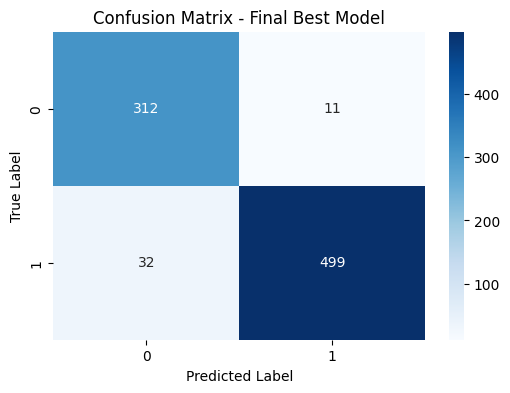


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       323
           1       0.98      0.94      0.96       531

    accuracy                           0.95       854
   macro avg       0.94      0.95      0.95       854
weighted avg       0.95      0.95      0.95       854



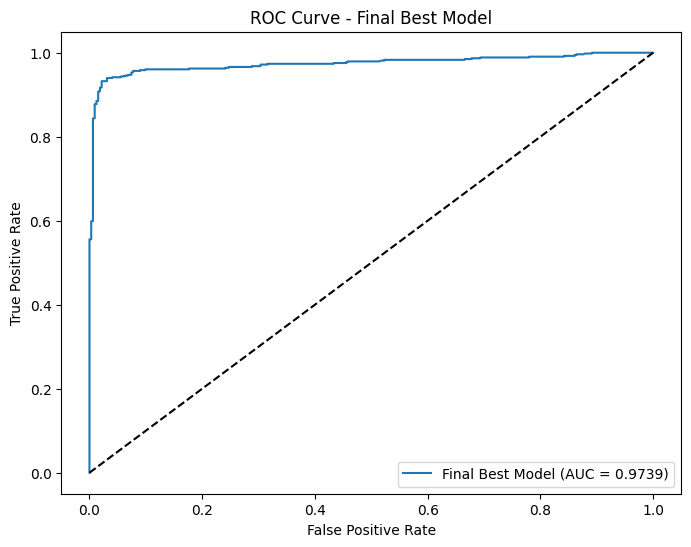

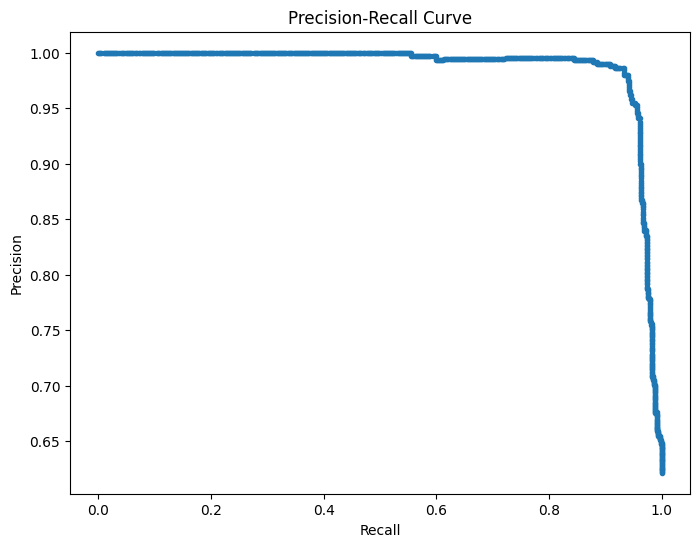


Best model saved as 'best_loan_approval_model.pkl'


In [19]:
# Section 10: Feature Importance and Final Evaluation
# Get feature importance from the best model
if hasattr(best_model.named_steps['classifier'], 'coef_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': abs(best_model.named_steps['classifier'].coef_[0])
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
    plt.title('Top 10 Feature Importance (Logistic Regression)')
    plt.tight_layout()
    plt.show()

# Final evaluation on the best model
print("FINAL MODEL EVALUATION")
final_results = evaluate_model(best_model, X_test_scaled, y_test, "Final Best Model")

# Precision-Recall Curve
y_prob_final = best_model.predict_proba(X_test_scaled)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_prob_final)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Save the best model
import joblib
joblib.dump(best_model, 'best_loan_approval_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("\nBest model saved as 'best_loan_approval_model.pkl'")